In [1]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure
import earthpy.plot as ep
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from skimage.filters import threshold_otsu
from shapely import Polygon
from shapely.affinity import affine_transform
import rasterio as rio
from rasterio.plot import reshape_as_image, show
import geopandas as gpd
import pandas as pd

In [2]:
lake = gpd.read_file("lake_polygon.geojson")

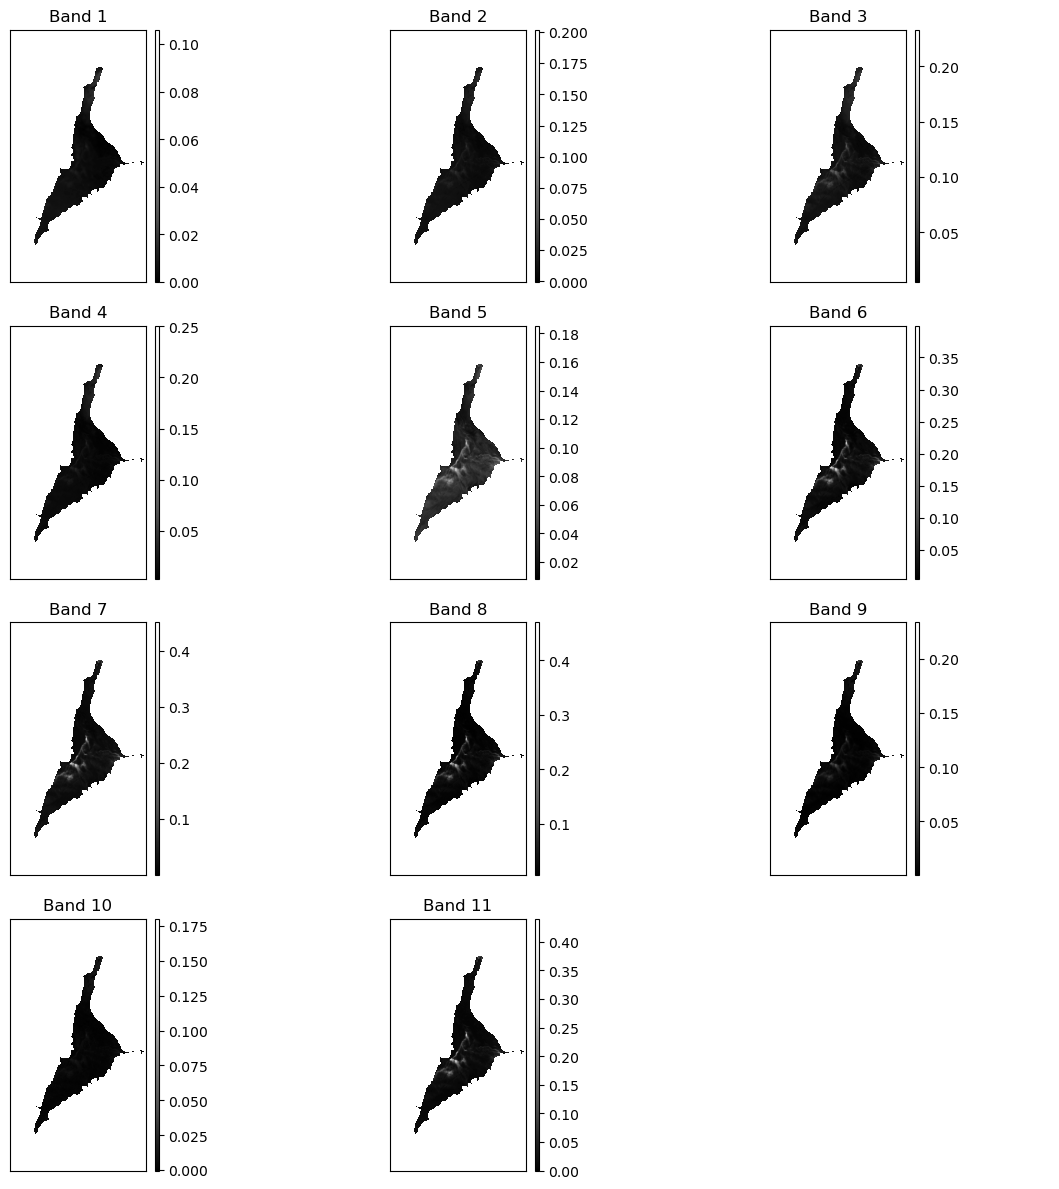

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>,
        <Axes: title={'center': 'Band 11'}>, <Axes: >]], dtype=object)

In [3]:
clipped = rxr.open_rasterio('output/stacked_BOA.tif').rio.clip(lake.geometry, from_disk = True)

ep.plot_bands(clipped)

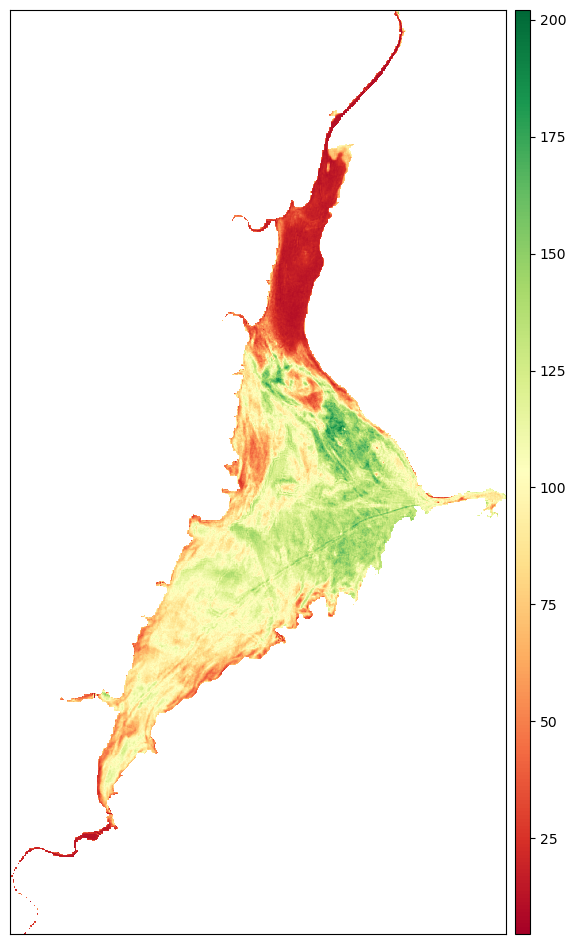

<Axes: >

In [4]:
def norm_diff(band1, band2):
    return (band1 - band2) / (band1 + band2)

# This is the normalized difference chlorophyll index as published by Mishra and Mishra 2012
# Uses bands 4 and 5 to create chlorophyll concentrations in mg/m3 
x = norm_diff(clipped[4], clipped[3])

ndci = 14.039 + 86.115*x + 194.325*x**2

ep.plot_bands(ndci, cmap = "RdYlGn")

In [5]:
# Compare with insitu data from 
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8898098

def convert(tude):
    """
    converts latitude/longitude in the form XX-XX-XX.X<N/S> to decimal degrees
    """
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))

# Read in data file
df = pd.read_csv("insitu_data.csv")

# Set to decimal degrees
df['lat_deg'] = df["Lat"].apply(lambda x: convert(x))
df['lon_deg'] = df["Lon"].apply(lambda x: convert(x))

# Create geodataframe
gdf = gpd.GeoDataFrame(
    {
        "site": df["Site"],
        "Chl-a 2/22": df["Chl-a 2/22"],
        "Chl-a 11/14": df["Chl-a 11/14"],
        "geometry": gpd.points_from_xy(
            df["lon_deg"], df["lat_deg"]
        )
    }, crs="EPSG:4326"
)

gdf = gdf.to_crs(clipped.rio.crs)

gdf

,site,Chl-a 2/22,Chl-a 11/14,geometry
0,Centro,127.1,221.32,POINT (360276.522 6527867.610)
1,Zona A,53.8,117.48,POINT (361637.929 6528218.304)
2,Zona B,288.5,52.31,POINT (361637.618 6527642.405)
3,Garganta,197.1,69.38,POINT (362879.385 6528049.868)
4,SAT 1,27.6,85.00,POINT (358875.607 6525751.534)
5,SAT 2,132.2,73.42,POINT (359660.290 6527123.318)
6,SAT 3,94.7,341.98,POINT (360861.307 6528996.399)
7,SAT 4,56.7,703.12,POINT (360017.182 6529477.891)


<Axes: >

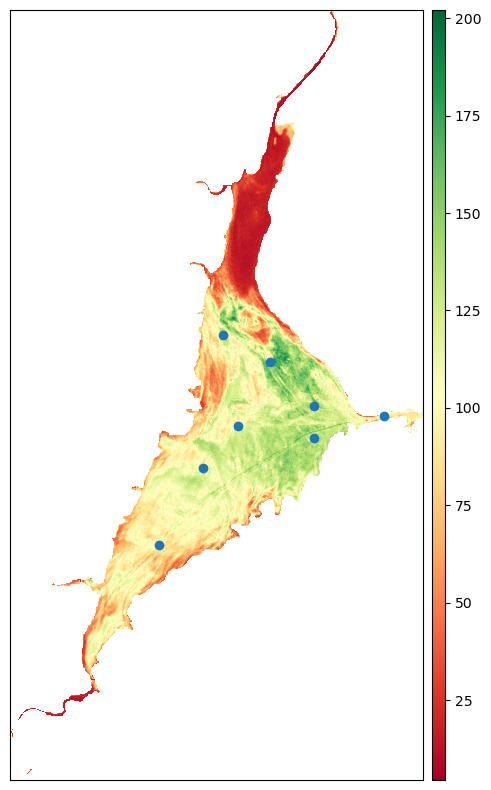

In [6]:
# Plot sampling locations on raster - remember that when using rioxarray, you need to use plotting_extent
from rasterio.plot import plotting_extent

fig, ax = plt.subplots(figsize = (10,10))

extent = plotting_extent(ndci.squeeze(), transform = ndci.rio.transform())

ep.plot_bands(ndci, ax = ax, extent = extent, cmap = "RdYlGn")
gdf.plot(ax = ax)

In [7]:
sampling_coords = [(x, y) for x,y in zip(gdf.geometry.x, gdf.geometry.y)]

# Grab NDCI values at each point
# Note that .values gives you a scalar ndarray, so you need to call the .item() method to get the actual value
gdf["ndci_values_20170222"] = [ndci.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

# NOTE: This basically does a "dot product" of the x and y values - if you provide 8 x values and 8 y values, you'll get 
# 64 results - we don't want that
# ndci.sel(x = gdf.geometry.x.values, y = gdf.geometry.y.values, method = "nearest")

gdf

,site,Chl-a 2/22,Chl-a 11/14,geometry,ndci_values_20170222
0,Centro,127.1,221.32,POINT (360276.522 6527867.610),111.139557
1,Zona A,53.8,117.48,POINT (361637.929 6528218.304),123.920883
2,Zona B,288.5,52.31,POINT (361637.618 6527642.405),141.046982
3,Garganta,197.1,69.38,POINT (362879.385 6528049.868),87.300995
4,SAT 1,27.6,85.00,POINT (358875.607 6525751.534),87.832832
5,SAT 2,132.2,73.42,POINT (359660.290 6527123.318),104.046021
6,SAT 3,94.7,341.98,POINT (360861.307 6528996.399),141.598984
7,SAT 4,56.7,703.12,POINT (360017.182 6529477.891),151.685669


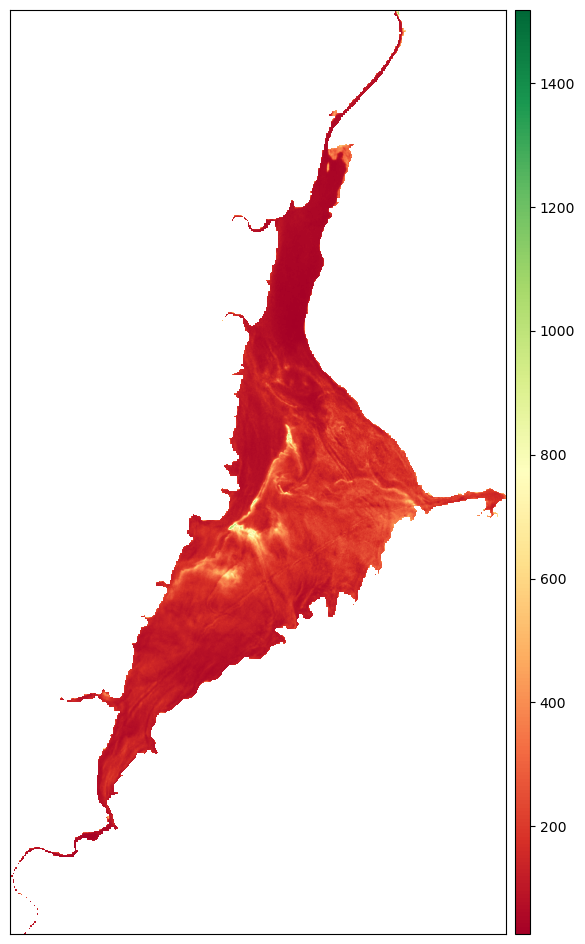

,site,Chl-a 2/22,Chl-a 11/14,geometry,ndci_values_20170222,san_roque_values_20170222
0,Centro,127.1,221.32,POINT (360276.522 6527867.610),111.139557,169.347412
1,Zona A,53.8,117.48,POINT (361637.929 6528218.304),123.920883,229.041260
2,Zona B,288.5,52.31,POINT (361637.618 6527642.405),141.046982,264.610199
3,Garganta,197.1,69.38,POINT (362879.385 6528049.868),87.300995,188.273788
4,SAT 1,27.6,85.00,POINT (358875.607 6525751.534),87.832832,104.094315
5,SAT 2,132.2,73.42,POINT (359660.290 6527123.318),104.046021,121.384323
6,SAT 3,94.7,341.98,POINT (360861.307 6528996.399),141.598984,146.384659
7,SAT 4,56.7,703.12,POINT (360017.182 6529477.891),151.685669,174.879669


In [8]:
# Algorithm used by Cordoba University
# 
san_roque = (clipped[7] / clipped[3])*80.748 - 8.024

gdf["san_roque_values_20170222"] = [san_roque.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

ep.plot_bands(san_roque, cmap = "RdYlGn")

gdf

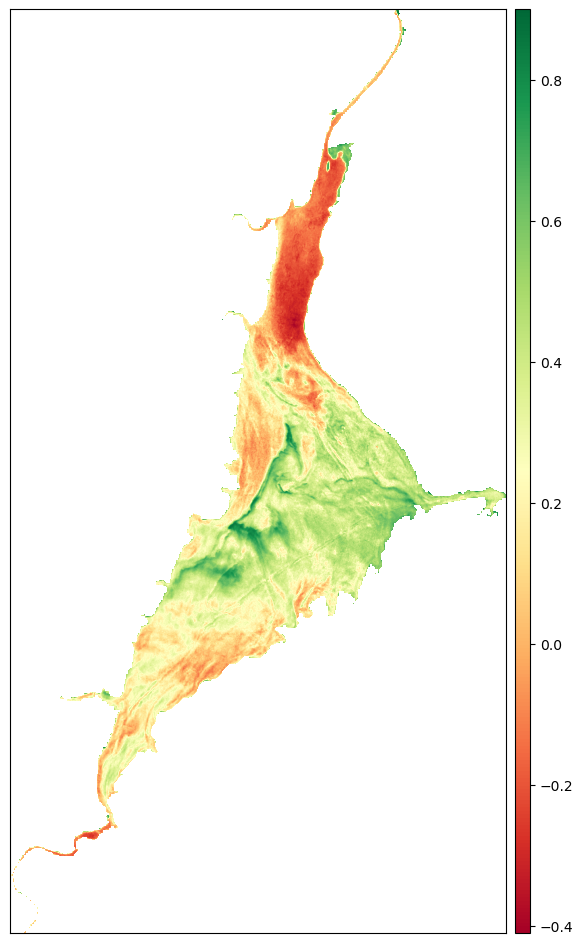

In [9]:
ndvi_clipped = norm_diff(clipped[7], clipped[3])

ep.plot_bands(ndvi_clipped, cmap = "RdYlGn")

ndvi_metric = [ndvi_clipped.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

# ratio = clipped[7] / clipped[3]

# [ratio.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

Slope: 378.8926376588416
Intercept: -16.13862963569352
Correlation coefficient: 0.5569919376448502
P-value: 0.15153791174081516
Standard error of the slope: 230.64318639474453


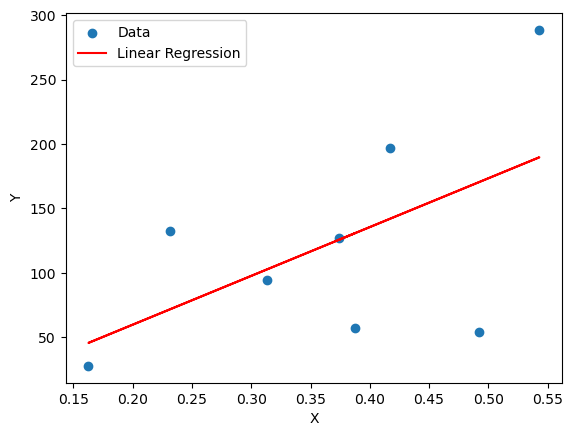

In [10]:
# Run linear regression on NDVI to see if good fit
from scipy.stats import linregress

y = gdf["Chl-a 2/22"]
x = ndvi_metric

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("Correlation coefficient:", r_value)
print("P-value:", p_value)
print("Standard error of the slope:", std_err)

# Plot the data and the regression line
plt.scatter(x, y, label='Data')
plt.plot(x, intercept + slope * np.array(x), color='red', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [11]:
ndvi_algo = ndvi_clipped * 378.89 - 16.13

gdf["ndvi_algo_values_20170222"] = [ndvi_algo.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

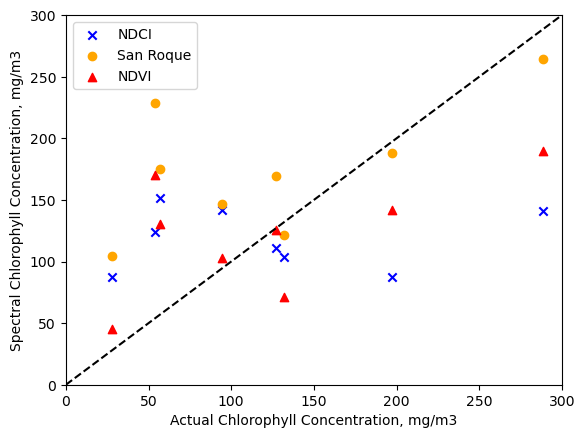

In [12]:
fig, ax = plt.subplots()

ax.scatter(gdf["Chl-a 2/22"], gdf["ndci_values_20170222"], label = "NDCI", c = "b", marker = "x")
ax.scatter(gdf["Chl-a 2/22"], gdf["san_roque_values_20170222"], label = "San Roque", c = "orange")
ax.scatter(gdf["Chl-a 2/22"], gdf["ndvi_algo_values_20170222"], label = "NDVI", c = "r", marker = "^")
ax.plot([0,300], [0,300], c = "k", linestyle = "--")
ax.set_xlabel("Actual Chlorophyll Concentration, mg/m3")
ax.set_ylabel("Spectral Chlorophyll Concentration, mg/m3")
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.legend()

In [13]:
# Compute errors between each value
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

metrics = list()

for dataset in ["ndci_values_20170222", "san_roque_values_20170222", "ndvi_algo_values_20170222"]: 
    
    y_test = gdf["Chl-a 2/22"]
    y_pred = gdf[dataset]
    
    mse = mean_squared_error(y_test, y_pred)

    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_test, y_pred)

    rsquared = r2_score(y_test, y_pred)

    max_error_value = max_error(y_test, y_pred)
    
    metrics.append([mse, rmse, mae, rsquared, max_error_value])

metrics_df = pd.DataFrame(metrics, columns = ["mse", "rmse", "mae", "rsquared", "max_error"], index = ["NDCI", "San Roque Algo", "NDVI"]).T

# Looks like both are really shit lmao
metrics_df

,NDCI,San Roque Algo,NDVI
mse,6826.540092,6968.633094,4488.951789
rmse,82.622879,83.478339,66.999640
mae,71.700602,63.422375,54.031310
rsquared,-0.048947,-0.070781,0.310240
max_error,147.453018,175.241260,116.428012


In [14]:
# Try to make a set of values that would be good

def prep_data(sampling_coords, list_of_features):
    """
    Extracts feature values from a list of raster features for a given set of points and prepares them in the form used by sklearn.
    
    Inputs:
    =======
    sampling_coords: List of tuples containing the x and y coordinates of the points
    list_of_features: 2D raster in the form of rioxarray 
        -Method is slightly different if you want to use rasterio: https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html
    """
    custom_data = np.array([], dtype = np.float32).reshape(0, len(sampling_coords))
    
    for data in list_of_features:
        layer = np.array([data.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords])
        custom_data = np.vstack((custom_data, layer))
        
    return custom_data.T
#     # 3 bands used in Gon
#     band4 = [clipped[3].sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]
#     band5 = [clipped[4].sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]
#     band7 = [clipped[6].sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

#     # ndvi + norm_diff used in mishra
#     ndvi = [norm_diff(clipped[7], clipped[3]).sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]
#     mishra = [norm_diff(clipped[4], clipped[3]).sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

In [15]:
X = prep_data(sampling_coords, 
              [clipped[3], clipped[4], clipped[6], norm_diff(clipped[7], clipped[3]), norm_diff(clipped[4], clipped[3])])

X

array([[0.01020356, 0.03224228, 0.02480105, 0.37433612, 0.51921988],
       [0.01323417, 0.04724517, 0.04290861, 0.49185255, 0.56235743],
       [0.01033789, 0.04360161, 0.04016498, 0.54299903, 0.61668587],
       [0.01104116, 0.02778088, 0.0310553 , 0.41707832, 0.43119091],
       [0.01332694, 0.0337052 , 0.02114641, 0.16265316, 0.4332839 ],
       [0.01116629, 0.03298302, 0.02666464, 0.23154347, 0.49415791],
       [0.00670319, 0.02842686, 0.01537362, 0.3132408 , 0.61837852],
       [0.00725237, 0.03403974, 0.02073466, 0.38746452, 0.64872849]])

In [16]:
y = gdf["Chl-a 2/22"]

X, y

(array([[0.01020356, 0.03224228, 0.02480105, 0.37433612, 0.51921988],
        [0.01323417, 0.04724517, 0.04290861, 0.49185255, 0.56235743],
        [0.01033789, 0.04360161, 0.04016498, 0.54299903, 0.61668587],
        [0.01104116, 0.02778088, 0.0310553 , 0.41707832, 0.43119091],
        [0.01332694, 0.0337052 , 0.02114641, 0.16265316, 0.4332839 ],
        [0.01116629, 0.03298302, 0.02666464, 0.23154347, 0.49415791],
        [0.00670319, 0.02842686, 0.01537362, 0.3132408 , 0.61837852],
        [0.00725237, 0.03403974, 0.02073466, 0.38746452, 0.64872849]]),
 0    127.1
 1     53.8
 2    288.5
 3    197.1
 4     27.6
 5    132.2
 6     94.7
 7     56.7
 Name: Chl-a 2/22, dtype: float64)

In [17]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X, y)

# Coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predictions
predictions = lr_model.predict(X)

In [18]:
coefficients, intercept

(array([-4.82438403e+05,  1.35533471e+05, -3.68046511e+02, -5.04550941e+02,
        -1.28154695e+04]),
 7520.687755068243)

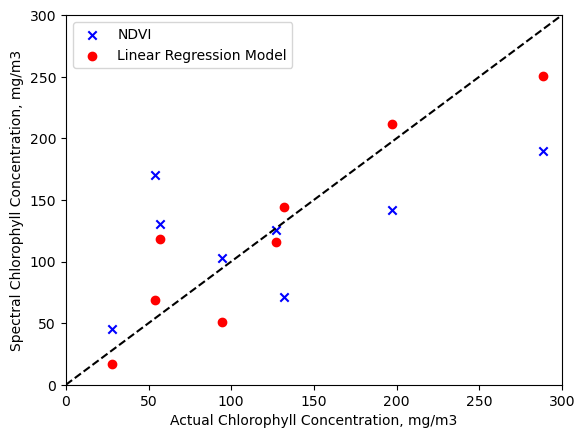

In [19]:
fig, ax = plt.subplots()

ax.scatter(gdf["Chl-a 2/22"], gdf["ndvi_algo_values_20170222"], label = "NDVI", c = "b", marker = "x")
ax.scatter(gdf["Chl-a 2/22"], predictions, label = "Linear Regression Model", c = "r")
ax.plot([0,300], [0,300], c = "k", linestyle = "--")
ax.set_xlabel("Actual Chlorophyll Concentration, mg/m3")
ax.set_ylabel("Spectral Chlorophyll Concentration, mg/m3")
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.legend()

In [20]:
y_test = gdf["Chl-a 2/22"]
y_pred = predictions

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

rsquared = r2_score(y_test, y_pred)

max_error_value = max_error(y_test, y_pred)

metrics_df["Linear_Model"] = [mse, rmse, mae, rsquared, max_error_value]

metrics_df

,NDCI,San Roque Algo,NDVI,Linear_Model
mse,6826.540092,6968.633094,4488.951789,993.348122
rmse,82.622879,83.478339,66.999640,31.517426
mae,71.700602,63.422375,54.031310,25.773250
rsquared,-0.048947,-0.070781,0.310240,0.847365
max_error,147.453018,175.241260,116.428012,61.802714


In [22]:
# Linear model is certainly the best, but it may be extremely overfitted.
# one way to check is to use the in-situ data from 14th November 2017 to check

features = [clipped[3], clipped[4], clipped[6], norm_diff(clipped[7], clipped[3]), norm_diff(clipped[4], clipped[3])]

lr_map = None

for i in range(5):
    
    if lr_map is None:
        lr_map = coefficients[i] * features[i]
    else:
        lr_map += coefficients[i] * features[i]

lr_map += intercept

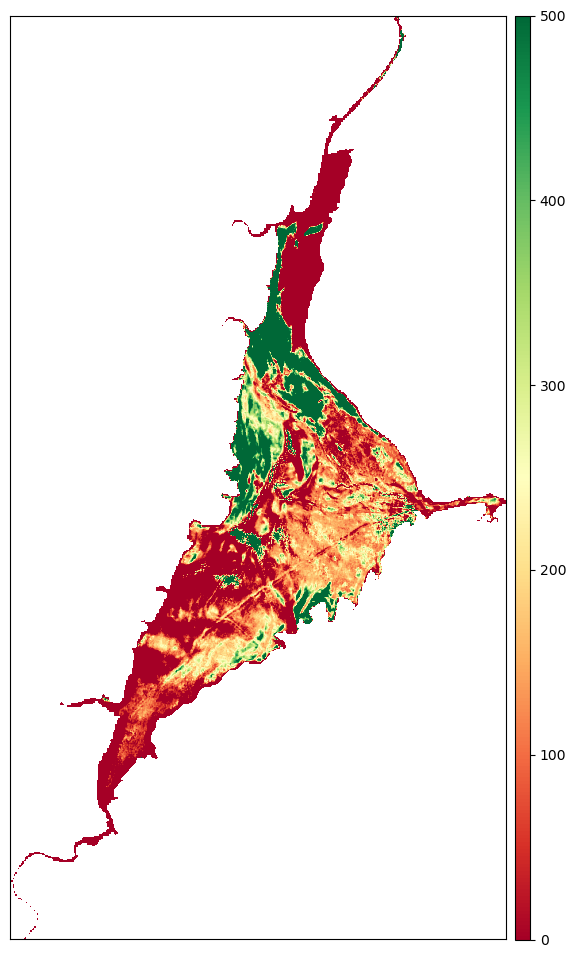

<Axes: >

In [25]:
# Map generated by linear model - looks extremely artificial
ep.plot_bands(lr_map, cmap = "RdYlGn", vmin = 0, vmax = 500)

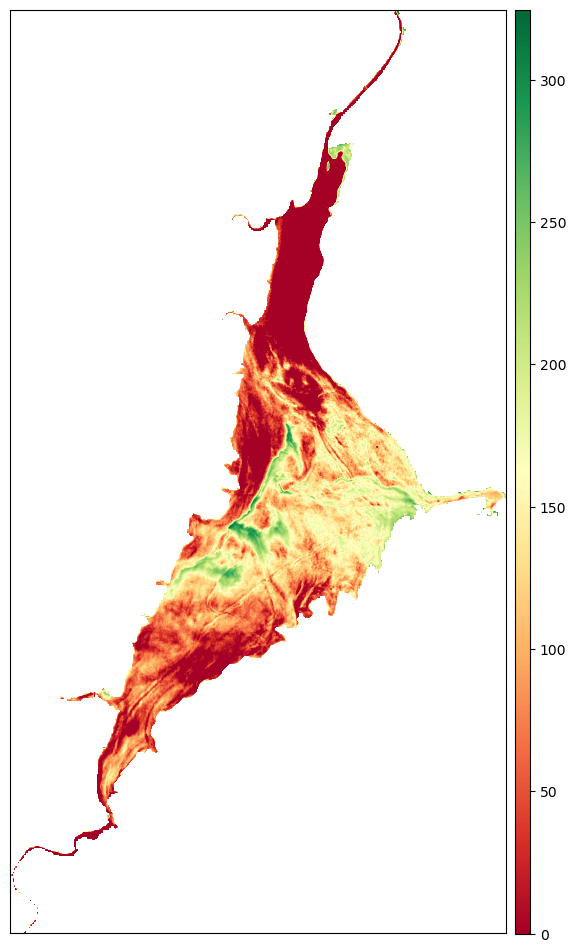

<Axes: >

In [29]:
# Chlorophyll map based on NDVI
ep.plot_bands(ndvi_algo, cmap = "RdYlGn", vmin = 0)

In [36]:
ndvi_algo.rio.write_nodata(np.nan, inplace = True)
ndvi_algo.rio.to_raster("output/ndvi_algo_20170222.tif")

Affine(10.0, 0.0, 356230.0,
       0.0, -10.0, 6535260.0)